# IMPORT LIBRARIES

In [1]:
import numpy 
import pandas 
import keras 
import tensorflow as tf 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

# LOAD DATASET

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv', index_col= 'DATE', parse_dates= True)

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


### NOTE:- CHANGE COLUMN TO PRODUCTION

In [4]:
df.columns = ['Producion']

In [5]:
df.head()

,Producion
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


## VISUALIZATION

<AxesSubplot:xlabel='DATE'>

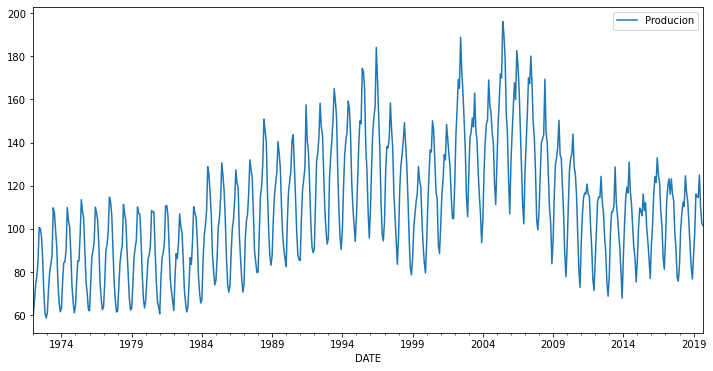

In [6]:
df.plot(figsize= (12,6))

# TRAIN TEST SPLIT 

In [7]:
len(df)

573

In [8]:
test_size = 24 
test_ind = len(df) - test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [10]:
len(test)

24

## SCALING

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [14]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## TIME SERIES GENERATOR

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

# BUILDING MODEL

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [18]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## CREATE GENERATOR FOR SCALED TEST/VALIDATION SET

In [20]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length= length, batch_size= 1)

## CREATE EARLYSTOPPING

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience= 2)

## TRAINING MODEL TO GENERATOR

In [23]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

C:\Users\sony\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
531/531 [==============================] - 6s 7ms/step - loss: 0.0295 - val_loss: 0.0102
Epoch 2/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0124 - val_loss: 0.0032
Epoch 3/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 4/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 5/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 6/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 7/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0030 - val_loss: 0.0047


In [24]:
loss = pd.DataFrame(model.history.history)

In [25]:
loss

,loss,val_loss
0,0.029509,0.010209
1,0.012364,0.003219
2,0.004932,0.001721
3,0.003594,0.004368
4,0.003381,0.001710
5,0.003121,0.002261
6,0.002951,0.004748


## VISUALIZATION

<AxesSubplot:>

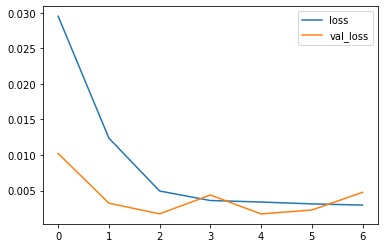

In [26]:
loss.plot()

## EVALUATE ON TEST DATA

In [27]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
test['Predictions'] = true_predictions

<ipython-input-29-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [30]:
test 

,Producion,Predictions
DATE,,
2017-10-01,90.4732,90.777790
2017-11-01,77.4378,86.628857
2017-12-01,75.8118,92.760068
2018-01-01,83.4343,108.475874
2018-02-01,99.4899,122.619145
2018-03-01,107.3152,134.003726
2018-04-01,112.4309,140.896980
2018-05-01,110.3544,142.236135
2018-06-01,124.5841,137.516625


## VISUALIZATION

<AxesSubplot:xlabel='DATE'>

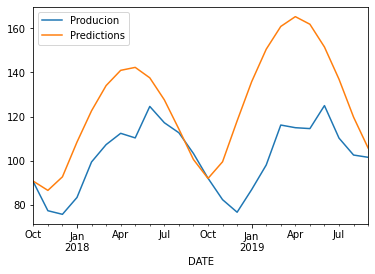

In [31]:
test.plot()

## EVALUATION

In [32]:
from sklearn.metrics import mean_squared_error 

In [33]:
np.sqrt(mean_squared_error(test['Producion'],test['Predictions']))

28.816657225823334

# GREAT JOB!